# General


## eval_mode parameter setting:

In [ ]:
eval_mode = True  # Set to True for evaluation-only mode

## Imports and given code, copied from "project_util.py":

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Resize
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from torchvision.transforms import Normalize
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline_model_path = "./baseline_model.pth"
osr_model_path = "./osr_model.pth"

def save_model(model, path):
    torch.save(model, path)

def load_model(path):
    model = torch.load(path, map_location=device)
    model.to(device)
    model.eval()  # Set to evaluation mode
    return model

In [ ]:
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            data, _ = self.ood[idx - len(self.mnist)]
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10

def eval_model(model, data_loader, device):  # changed slightly to support confusion matrices and the output of the OSR model
    """
    Evaluates the OSR model by computing accuracy on MNIST (known classes), OOD (unknown classes),
    and total accuracy. Additionally, returns all labels and predictions for confusion matrix evaluation.

    Key differences from the alternative implementation:
    - Returns `all_labels` and `all_preds` for later confusion matrix computation.
    - Explicitly flattens image data before feeding into the model.
    - Ensures `outputs` is correctly unpacked when the model returns multiple values.
    """
    model.eval()
    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    all_preds, all_labels = [], [] # Stores all predictions and labels for confusion matrices

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            data = data.view(-1, 28*28)

            outputs, _ = model(data)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]
            pred_mnist = preds[mask_mnist]
            pred_ood = preds[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total, all_labels, all_preds

##Quick Tuning Section (Hyperparameters, training and evaluation):

In [ ]:
'''Model Hyperparameters'''
embedding_space = 32  # size of the embedded space, aka the output of the final encoder layer

'''Training Hyperparameters'''
contrastive_weight = 1  # default contrastive weight for the contrastive loss weight within the combined loss in the training function
margin_diff = 1  # default value for the min. distance value for differently labelled objects in contrastive loss computation

batch_size = 200
baseline_num_epochs = 100
OSR_num_epochs = 300
lr = 0.01
step_size = 25
decay = 0.4
z_scalar = 3  # a scalar for the maximum deviation from the norm that determines the rejection threshold, determined using the normal distribution numeric chart (z score table).
             # for example: a value of 3 will put a threshold that's above ~99.7% of the trained images

'''Evaluation Hyperparameters'''
print_recon = True

# Data & Preprocessing

In [ ]:
def sample_ood(dataset, num_samples=1000):
    """
    Samples num_samples from dataset

    Args:
        dataset (Dataset): The dataset to sample from.
        num_samples (int): The numer of samples needed to be sampled. Defaults to 1000.

    Returns:
        Dataset: the subset of the dataset
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)  # Random subset
    return Subset(dataset, indices)

transform_original = transforms.Compose([Resize((28, 28)),ToTensor(),Normalize((0.5,), (0.5,))])
ood_transform = transforms.Compose([Resize((28, 28)), transforms.Grayscale(num_output_channels=1), ToTensor(), Normalize((0.5,), (0.5,))])

MNIST_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_original)
MNIST_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_original)

# CIFAR10 as OOD
ood_cifar = CIFAR10(root='./data', train=False, download=True, transform=ood_transform)
ood_cifar.targets = [10] * len(ood_cifar)  # Set all labels to 10 ("Unknown")
ood_cifar = sample_ood(ood_cifar)  # 1000 samples

# and FashionMNIST as OOD
ood_fashion = FashionMNIST(root='./data', train=False, download=True, transform=ood_transform)
ood_fashion.targets = [10] * len(ood_fashion)  # Set all labels to 10 ("Unknown")
ood_fashion = sample_ood(ood_fashion)  # 1000 samples, when combined with CIFAR10 will be 2000

# Combined OOD dataset - CIFAR10 & FashionMNIST
combined_ood_cf = torch.utils.data.ConcatDataset([ood_cifar, ood_fashion])

# Combine MNIST and OOD for OSR evaluation
combined_Mtest_w_FnC = CombinedDataset(MNIST_testset, combined_ood_cf)

torch.manual_seed(0)
np.random.seed(0)

train_size = len(MNIST_trainset)
train_idx = np.arange(train_size)
train_subset_idx = np.random.choice(train_idx, 2000)
train_subset_sampler = SubsetRandomSampler(train_subset_idx)
trainloader_sized = DataLoader(MNIST_trainset, batch_size=batch_size, sampler=train_subset_sampler)

mnist_test_loader = DataLoader(MNIST_testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


# Models:

## Baseline model class & OSR model class:

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder_init = nn.Sequential(
            nn.Unflatten(1, (1, 28, 28)) #  reshapes input to image format
        )
        self.encoder_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2,2), #  downsamples the image
            ),
            nn.Sequential(
                nn.Conv2d(in_channels=16, out_channels=4, kernel_size=3, padding=1),
                nn.BatchNorm2d(4),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
            ),
            nn.Sequential(
                nn.Flatten(),
                nn.BatchNorm1d(4 * 7 * 7),
                nn.Linear(4 * 7 * 7, embedding_space),
                nn.SiLU(),
            )
        ])

        self.decoder_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embedding_space, 4 * 7 * 7),
                nn.BatchNorm1d(4 * 7 * 7),
                nn.Unflatten(1, (4, 7, 7)), #  reshapes back to feature map
            ),
            nn.Sequential(
                nn.ConvTranspose2d(in_channels=4, out_channels=16, kernel_size=2, stride=2),
                nn.BatchNorm2d(16),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2),
                nn.Tanh(), #  output normalized to [-1,1]
                nn.Flatten(),
            )
        ])

    #we made the forward function modular by splitting it into two here, to make the forward function in the ML_autoencoder_OSR more easily adjustable.
    def encode(self, x):
        encoded_features = []
        input = self.encoder_init(x)
        for i in range(len(self.encoder_layers)):
            input = self.encoder_layers[i](input)
            encoded_features.append(input)  #  stores intermediate encoded layers
        return encoded_features

    def decode(self, encoded_features):
        x = encoded_features[-1] #  uses the final encoded vector
        for i in range(len(self.decoder_layers)):
          x = self.decoder_layers[i](x)
        recon = x # reconstructed output
        return recon

    def forward(self, x):
        encoded_features = self.encode(x)
        recon = self.decode(encoded_features)
        return recon


class classifier(nn.Module): #this is the Baseline Model, which is also integrated into the OSR_model
   def __init__(self):
      super(classifier, self).__init__()

      self.n_classes = 10 #  classifier for MNIST

      self.classifier_init = nn.Sequential(
            nn.Unflatten(1, (1, 28, 28))
        )

      self.augmentation = transforms.Compose([
                              transforms.Resize((28, 28)),
                              transforms.RandomRotation(degrees=8),
                              transforms.RandomAffine(degrees=0, shear=0.3),
                              transforms.RandomResizedCrop(size=28, scale=(1-0.08, 1+0.08)),
                              transforms.RandomAffine(degrees=0, translate=(0.08, 0.08)),
                              transforms.Normalize((0.5,), (0.5,))
                            ])  # data augmentation for training, used in the forward function below

      self.CNN_features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
        )

      self.CNN_predictions = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, self.n_classes),
            nn.LogSoftmax(dim=1),
        )

   def forward(self, x):
        input = self.classifier_init(x)
        if self.training:
            batch_size = input.size(0)
            split = int(batch_size * 0.5)  # split batch for augmentation
            original_input = input[:split]
            augmented_input = input[split:]
            augmented_input = self.augmentation(augmented_input)
            input = torch.cat([original_input, augmented_input], dim=0)

        embeddings = self.CNN_features(input) #  capturing the learned features to improve our clustering via contrastive loss during training
        preds = self.CNN_predictions(embeddings)
        return preds, embeddings


class OSR_model(nn.Module):
   def __init__(self):
    super(OSR_model, self).__init__()
    self.threshold = 0
    self.autoencoder = autoencoder().to(device)  # adding both models as attributes
    self.classifier = classifier().to(device)

   def forward(self, x):
    input = x
    recon = self.autoencoder(input)

    if not self.training:
      recon_loss = torch.mean((recon - x) ** 2, dim=1)

    preds, embeddings = self.classifier(input)  # gets the predictions from the classifier

    if not self.training:  # OOD determination in evaluation only
      unknown_class = torch.full((preds.shape[0], 1), -1e16, device=preds.device)
      preds = torch.concat([preds, unknown_class], dim=1)  # effectively this creates a new prediction tensor with 11 classes, where the unknown class has a near infinitely small chance of having the highest value.
      is_ood = recon_loss > self.threshold  # boolean mask for all indices within the batch that exceed the rejection threshold
      for i in range(len(is_ood)):
        if is_ood[i]:  # if true, then this index of recon_loss satisfied the rejection threshold inequation
          preds[i, :10] = 0
          preds[i, 10] = 1  # assigns unknown class
      return preds, recon

    return preds, recon, embeddings

# Training

**Training procedures for both models:**

In [ ]:
def compute_contrastive_loss(embeddings, labels, margin_diff=1.0):
    """
    Computes the contrastive loss based on embedding distances.

    Args:
        embeddings (torch.Tensor): A tensor of shape (batch_size, embedding_dim) containing feature embeddings.
        labels (torch.Tensor): A tensor of shape (batch_size,) containing class labels for each sample.
        margin_diff (float, optional): The margin for samples of different classes. Defaults to 1.0.

    Returns:
        torch.Tensor: The computed contrastive loss.
    """
    batch_size = embeddings.size(0)
    if batch_size <= 1:
        return torch.tensor(0.0).to(embeddings.device)

    distances = torch.cdist(embeddings, embeddings, p=2)
    labels_matrix = labels.unsqueeze(0) == labels.unsqueeze(1)
    positive_pairs = labels_matrix.logical_xor(torch.eye(batch_size, device=embeddings.device).bool())
    negative_pairs = ~labels_matrix

    # Hard negative mining: Only consider the closest negative pairs
    hardest_neg_dist, _ = torch.min(distances * negative_pairs.float() + 1e6 * ~negative_pairs, dim=1)
    negative_loss = torch.clamp(margin_diff - hardest_neg_dist, min=0).mean()

    # Normal positive loss
    positive_loss = (distances * positive_pairs.float()).sum() / positive_pairs.sum().clamp(min=1)

    return positive_loss + negative_loss


def train_model(is_baseline, margin, num_epochs, contrastive_weight, step_size, decay, z_scalar):
    """
    Trains either the baseline classifier or the OSR model.

    Args:
        is_baseline (bool): If True, trains the baseline model; otherwise, trains the OSR model.
        margin (float, optional): Margin used for contrastive loss. Defaults to 1.0.
        num_epochs (int, optional): Number of training epochs. Defaults to 300.
        contrastive_weight (float, optional): Weight of contrastive loss in the total loss function. Defaults to 0.05.
        step_size (int, optional): Step size for the learning rate scheduler. Defaults to 10.
        decay (float, optional): Learning rate decay factor. Defaults to 0.5.
        z_scalar (int, optional): Scalar for computing the OOD threshold in OSR. Defaults to 3.

    Returns:
        torch.nn.Module: The trained model. Alsp displays a matplotlib figure presenting the training losses with the loss types corresponding to the classifier or OSR model.
    """
    criterion = nn.MSELoss() if not is_baseline else None  # MSE loss only for OSR model (reconstruction loss)
    clf_criterion = nn.CrossEntropyLoss()  # Classification loss, for both trainings

    model = classifier().to(device) if is_baseline else OSR_model().to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=decay)

    # Track losses
    loss_train_clf, loss_train_contrastive = [], []
    loss_train_recon = [] if not is_baseline else None
    last_epoch_recon_errors = torch.tensor([]) if not is_baseline else None

    for epoch in tqdm(range(num_epochs)):
        loss_clf_epoch, loss_contrastive_epoch = 0, 0
        loss_recon_epoch = 0 if not is_baseline else None

        for data in trainloader_sized:
            optimizer.zero_grad()
            img, labels = data
            img = img.view(img.size(0), -1).to(device)
            labels = labels.to(device)

            if is_baseline:
                preds, embeddings = model(img)  # only classification output for baseline model
            else:
                preds, recon, embeddings = model(img)  # OSR model also outputs reconstructed images

                # Compute reconstruction loss for OSR model
                loss_recon_batch = criterion(recon, img)
                if epoch == num_epochs - 1:
                    sample_recon_error = torch.mean((recon - img) ** 2, dim=1).detach().cpu()
                    last_epoch_recon_errors = torch.cat([last_epoch_recon_errors, sample_recon_error])
                loss_recon_epoch += loss_recon_batch.item()

            # Compute classification and contrastive losses
            loss_clf_batch = clf_criterion(preds, labels)
            loss_contrastive_batch = compute_contrastive_loss(embeddings, labels, margin_diff=margin) / embeddings.size(1)

            # Total loss calculation
            loss = loss_clf_batch + contrastive_weight * loss_contrastive_batch
            if not is_baseline:
                loss += loss_recon_batch

            loss.backward()
            optimizer.step()

            # Accumulate losses
            loss_clf_epoch += loss_clf_batch.item()
            loss_contrastive_epoch += loss_contrastive_batch.item()

        # Epoch losses
        loss_train_clf.append(loss_clf_epoch / len(trainloader_sized))
        loss_train_contrastive.append(loss_contrastive_epoch / len(trainloader_sized))
        if not is_baseline:
            loss_train_recon.append(loss_recon_epoch / len(trainloader_sized))

        scheduler.step()

    # Set OOD detection threshold for OSR model based on reconstruction errors
    if not is_baseline:
        recon_err = last_epoch_recon_errors.clone().detach().cpu()
        mean = torch.mean(recon_err)
        std = torch.std(recon_err)
        model.threshold = mean + z_scalar * std
        print(f"\nThreshold: {model.threshold}\nMean: {mean}\nStd: {std}")

    print(f"Final classification loss: {loss_train_clf[-1]}")
    print(f"Final contrastive loss: {loss_train_contrastive[-1]}")

    if not is_baseline:
        print(f"Final reconstruction loss: {loss_train_recon[-1]}")
        plt.plot(loss_train_recon, label="Reconstruction Loss", color='green')

    # Plot classification and contrastive losses
    plt.plot(loss_train_clf, label="Classification Loss", color='blue')
    plt.plot(loss_train_contrastive, label="Contrastive Loss", color='orange')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.title("Baseline Model Training Losses" if is_baseline else "OSR Model Training Losses")
    plt.show()

    return model

Training models...


100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


Final classification loss: 0.015810568793676795
Final contrastive loss: 0.0314013633877039


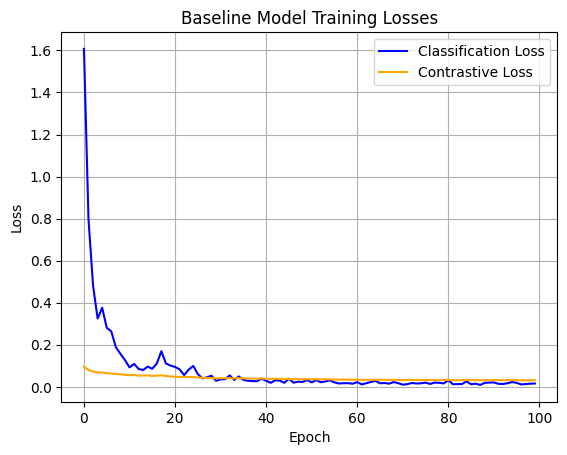

100%|██████████| 300/300 [04:23<00:00,  1.14it/s]


Threshold: 0.10214029252529144
Mean: 0.043423380702733994
Std: 0.01957230269908905
Final classification loss: 0.010908865137025714
Final contrastive loss: 0.028902561217546464
Final reconstruction loss: 0.04342338293790817


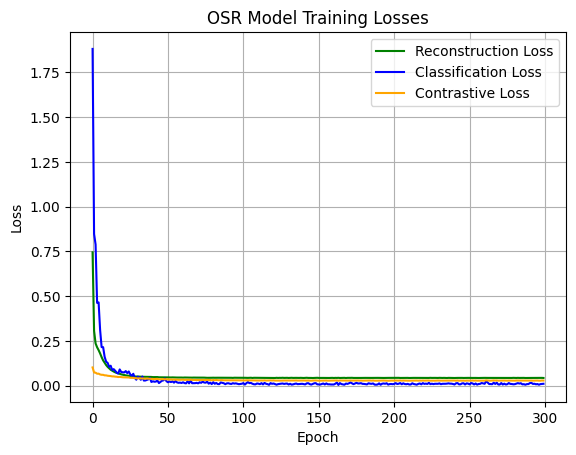

Training complete. Models saved.


In [ ]:
# ---------------- Training Mode ---------------- #
if not eval_mode:
    print("Training models...")
    # Train and save baseline model
    baseline_model_trained = train_model(is_baseline=True, margin=margin_diff, num_epochs=baseline_num_epochs, contrastive_weight=contrastive_weight, step_size=step_size, decay=decay, z_scalar=z_scalar)
    save_model(baseline_model_trained, baseline_model_path)

    # Train and save OSR model
    OSR_model_trained = train_model(is_baseline=False, num_epochs=OSR_num_epochs, contrastive_weight=contrastive_weight, margin=margin_diff, step_size=step_size, decay=decay, z_scalar=z_scalar)
    save_model(OSR_model_trained, osr_model_path)

    print("Training complete. Models saved.")

# Evaluation - Baseline and CIFAR10/Fashion-MNIST

In [ ]:
# ---------------- Evaluation Mode ---------------- #
if eval_mode:
    print("Loading trained models...")

    baseline_model_trained = load_model(baseline_model_path)
    OSR_model_trained = load_model(osr_model_path)

    print("Evaluation complete.")

Loading trained models...
Evaluation complete.


<ipython-input-73-011bf179e4c7>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)


In [ ]:
def evaluate_and_visualize(model, dataloader, device="cpu", n_samples=10):
    """
    Evaluates the OSR model by visualizing original images, reconstructions, and predictions.

    Args:
        model (torch.nn.Module): Trained OSR model.
        dataloader (DataLoader): DataLoader containing test samples.
        device (str, optional): device to perform inference on (e.g., "cpu" or "cuda"). Defaults to "cpu".
        n_samples (int, optional): Number of samples to visualize. Defaults to 10.

    Returns:
        None: Displays a matplotlib figure with original images, reconstructions, predictions, and true labels.
    """
    model.eval()
    images, recons, preds, true_labels = [], [], [], []

    with torch.no_grad():
        data, labels = next(iter(dataloader))
        data = data.view(-1, 28*28).to(device)
        labels = labels.to(device) if labels is not None else torch.full((len(data),), 10, dtype=torch.long)

        pred_logits, reconstructions = model(data)
        _, pred_labels = torch.max(pred_logits, 1)  # convert logits to class predictions
        reconstructions = reconstructions.view(-1, 28, 28).cpu()  # reshape reconstructions
        data = data.view(-1, 28, 28).cpu()
        labels = labels.cpu()

        # Store selected sample results
        for img, recon, pred, label in zip(data, reconstructions, pred_labels, labels):
            images.append(img)
            recons.append(recon)
            preds.append(pred.item())
            true_labels.append(label.item() if label is not None else 10) # assign 10 for unknown classes
            if len(images) == n_samples:
                break

    fig, axes = plt.subplots(n_samples, 4, figsize=(12, 2 * n_samples))

    for i in range(n_samples):
        axes[i, 0].imshow(images[i], cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(recons[i], cmap='gray')
        axes[i, 1].set_title('Reconstruction')
        axes[i, 1].axis('off')

        axes[i, 2].text(0.5, 0.5, str(preds[i]), fontsize=14, ha='center')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

        axes[i, 3].text(0.5, 0.5, str(true_labels[i]), fontsize=14, ha='center')
        axes[i, 3].set_title('True Label')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, dataset_name):
    """
    Plots a confusion matrix for the OSR model with 11 classes (digits 0-9 and unknown class 10).

    Args:
        y_true (list): List of true class labels.
        y_pred (list): List of predicted class labels.
        dataset_name (str): Name of the dataset being evaluated (used for the plot title).

    Returns:
        None: Displays a heatmap visualization of the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred, labels=list(range(11)))  # 11 classes: 0-9 + 10 (Unknown)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(11)), yticklabels=list(range(11)))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"OSR Model's accuracy, with OOD - {dataset_name}")
    plt.show()

##Baseline results

Baseline Model Total Accuracy: 97.79%


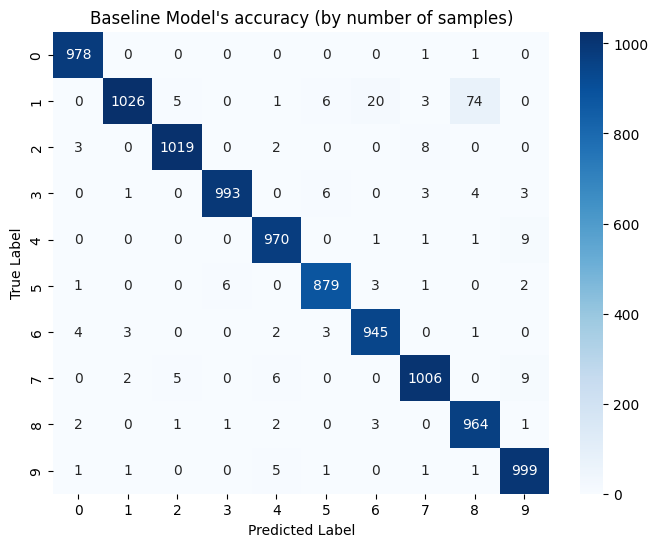

In [ ]:
def evaluate_model_accuracy(model, test_loader, device="cpu", class_names=None):
    """
    Evaluates the model by computing accuracy and displaying a confusion matrix.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (str, optional): Device to run the model on (e.g., "cpu" or "cuda"). Defaults to "cpu".
        class_names (list, optional): List of class names for labeling the confusion matrix. Defaults to None.

    Returns:
        None: Prints the accuracy of the model and displays a confusion matrix plot.
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1)  # flatten if necessary

            outputs, _ = model(images)
            _, preds = torch.max(outputs, 1)  # get predicted class

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Baseline Model Total Accuracy: {accuracy * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Baseline Model's accuracy (by number of samples)")
    plt.show()

# Define class names (for MNIST, use digits 0-9)
class_names = [str(i) for i in range(10)]  # ["0", "1", ..., "9"]

# Run evaluation on the baseline model
if eval_mode:
  evaluate_model_accuracy(baseline_model_trained, mnist_test_loader, device=device, class_names=class_names)


##OOD Results

In [ ]:
def eval_binary_classification(model, data_loader, device):
    """
    Evaluates the OSR model as a binary classifier, distinguishing between known (MNIST classes 0-9)
    and unknown (OOD class 10) samples. Computes accuracy and displays a confusion matrix.

    Args:
        model (torch.nn.Module): The trained OSR model.
        data_loader (DataLoader): DataLoader containing the test dataset.
        device (str): Device to run the model on (e.g., "cpu" or "cuda").

    Returns:
        None: Prints binary classification accuracy and displays a confusion matrix.
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1)  # flatten images

            outputs, _ = model(images)
            _, preds = torch.max(outputs, 1)

            # Convert labels to binary (0 = MNIST, 1 = OOD)
            binary_labels = (labels == 10).long() # if 10, then 1 for unknown
            binary_preds = (preds == 10).long() # same

            all_preds.extend(binary_preds.cpu().numpy())
            all_labels.extend(binary_labels.cpu().numpy())

    # Compute binary accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Binary Classification Total Accuracy (Known vs Unknown): {accuracy * 100:.2f}%")

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Known (0-9)", "Unknown (OOD)"],
                yticklabels=["Known (0-9)", "Unknown (OOD)"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("OSR model's binary accuracy (Known vs Unknown samples)")
    plt.show()

FashionMNIST and CIFAR10 as OOD:

Binary Classification Total Accuracy (Known vs Unknown): 98.42%


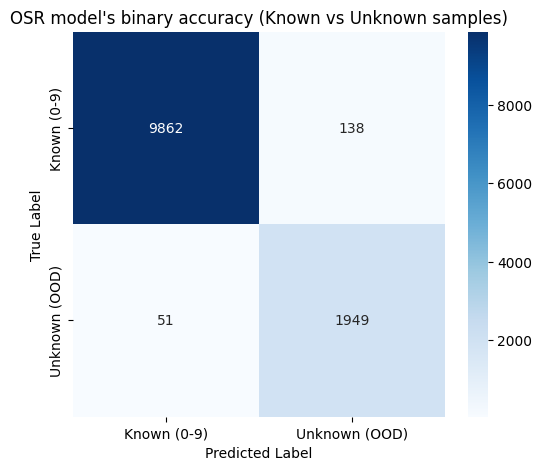

In [ ]:
if eval_mode:
    osr_loader = DataLoader(combined_Mtest_w_FnC, batch_size=batch_size, shuffle=False)
    print("FashionMNIST and CIFAR10 as OOD:\n")
    eval_binary_classification(OSR_model_trained, osr_loader, device)

##OSR Results

FashionMNIST and CIFAR10 as OOD:

Accuracy on MNIST: 96.61%
Accuracy on OOD: 97.45%
Total Accuracy: 96.75%



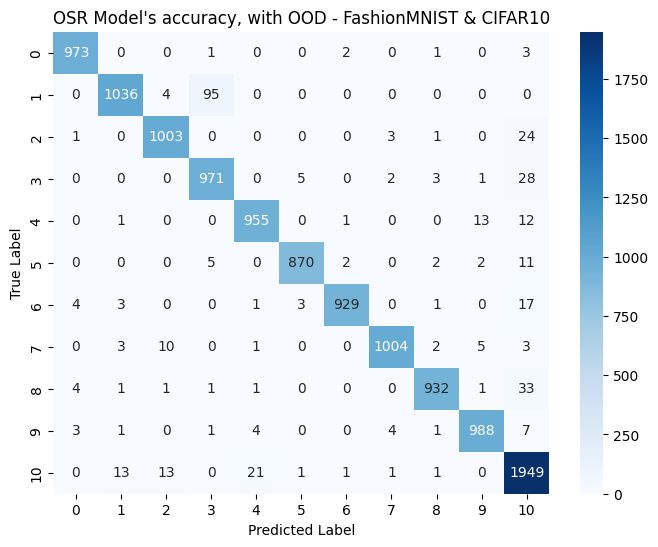

In [ ]:
if eval_mode:
    print("FashionMNIST and CIFAR10 as OOD:\n")

    acc_mnist, acc_ood, acc_total, y_true, y_pred = eval_model(OSR_model_trained, osr_loader, device)

    print(f"Accuracy on MNIST: {acc_mnist:.2%}")
    print(f"Accuracy on OOD: {acc_ood:.2%}")
    print(f"Total Accuracy: {acc_total:.2%}\n")

    plot_confusion_matrix(y_true, y_pred, "FashionMNIST & CIFAR10")

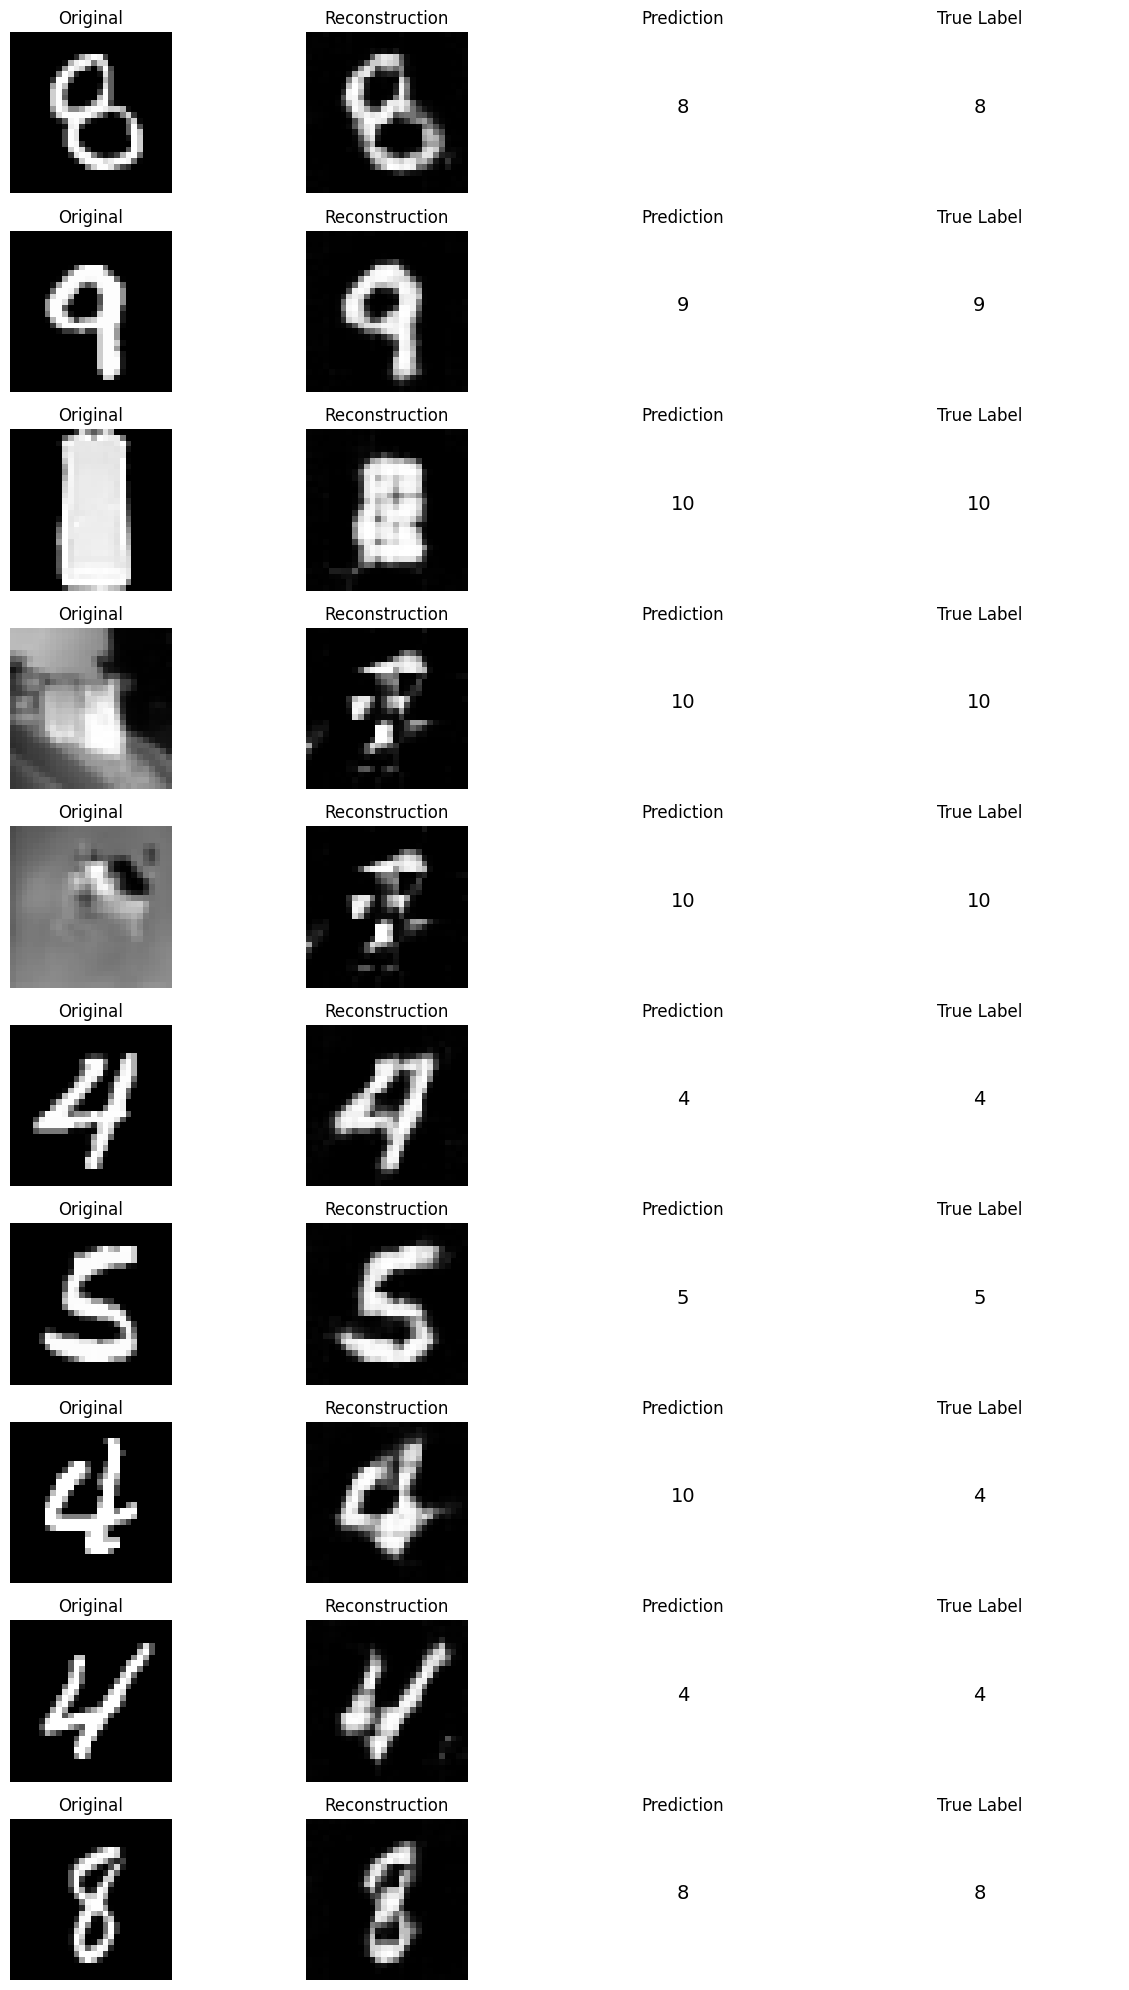

In [ ]:
if eval_mode and print_recon: # showing the difference in reconstruction between samples from the trained distribution in constrast to those from the OOD
  evaluate_and_visualize(OSR_model_trained, osr_loader, device)

##t-SNE visualization

In [ ]:
def extract_embeddings_and_predictions(dataloader, model, device):
    """
    Extracts embeddings and predicted labels from the trained model.

    Args:
        dataloader (DataLoader): DataLoader containing test samples.
        model (torch.nn.Module): The trained OSR model.
        device (str): Device to run inference on (e.g., "cpu" or "cuda").

    Returns:
        tuple:
            - np.ndarray: Extracted feature embeddings of shape (num_samples, embedding_dim).
            - np.ndarray: Predicted labels of shape (num_samples,).
    """
    model.eval()
    embeddings, predicted_labels = [], []

    with torch.no_grad():
      for images, _ in dataloader:
          images = images.view(images.size(0), -1).to(device)  # flatten images

          # Ensure the model always returns embeddings
          outputs = model(images)

          if len(outputs) == 3:
              preds, _, embed = outputs  # training mode
          else:
              preds, recon = outputs  # evaluation mode
              embed = model.autoencoder.encode(images)[-1]  # extract from encoder

          _, pred_labels = torch.max(preds, 1)  # convert logits to class predictions

          embeddings.append(embed.cpu().numpy())
          predicted_labels.append(pred_labels.cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)  # merge batch embeddings
    predicted_labels = np.concatenate(predicted_labels, axis=0)  # Merge batch labels

    return embeddings, predicted_labels



def tsne_plot(embeddings, labels, title="t-SNE Visualization"):
    """
    Applies t-SNE to embeddings and visualizes them in a 2D space.

    Args:
        embeddings (np.ndarray): High-dimensional feature representations of shape (num_samples, embedding_dim).
        labels (np.ndarray): Corresponding class labels for embeddings.
        title (str, optional): Title for the t-SNE plot. Defaults to "t-SNE Visualization".

    Returns:
        None: Displays a scatter plot of the embeddings using t-SNE.
    """
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=750) #changed from 1000 (the default) to reduce runtime
    tsne_results = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))

    distinct_colors = [
        "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231",
        "#911eb4", "#46f0f0", "#f032e6", "#bcf60c", "#fabebe",
        "#404040"  # Dark gray for OOD (Class 10)
    ]

    unique_labels = np.unique(labels)

    for label in unique_labels:
        idx = labels == label # Select points for each label
        color = distinct_colors[label]
        plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1],
                    label=f'Class {label}', alpha=0.7, s=50, edgecolors='black',
                    color=color)

    plt.legend(frameon=True, loc="best", fontsize=10)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(visible=True, linestyle="--", alpha=0.6)
    plt.show()


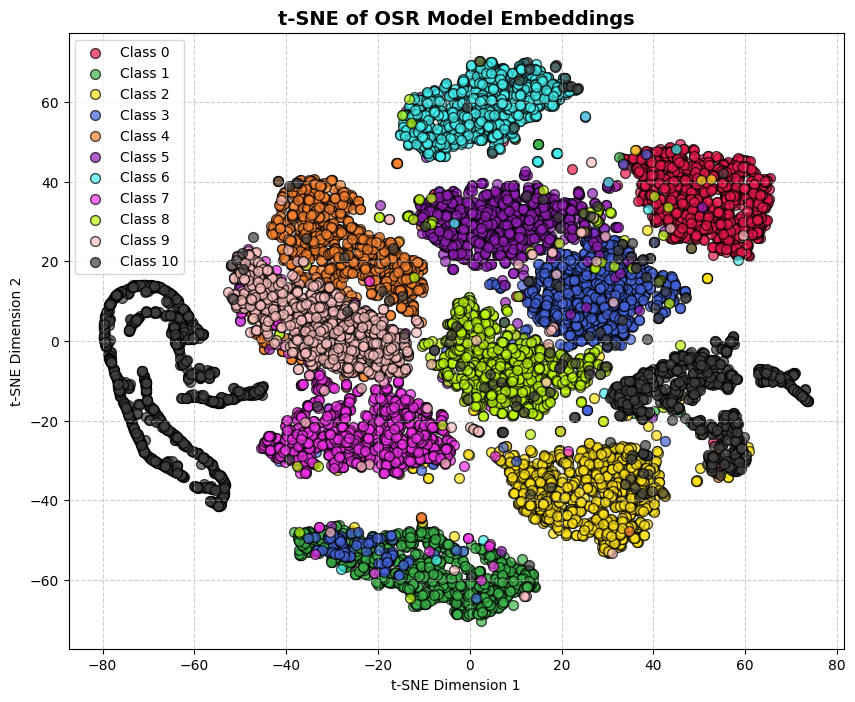

In [ ]:
if eval_mode:
  # Get embeddings and predicted labels from the trained OSR model
  test_loader = DataLoader(combined_Mtest_w_FnC, batch_size=100, shuffle=False)
  embeddings, pred_labels = extract_embeddings_and_predictions(test_loader, OSR_model_trained, device)

  # Plot t-SNE visualization of the learned embeddings
  tsne_plot(embeddings, pred_labels, title="t-SNE of OSR Model Embeddings")

# Evaluation - Unknown Dataset

## Dataset Setting

In [ ]:
if eval_mode:
  osr_dataset = None # to be changed by grader, make sure to use transform=ood_transform!
  # osr_dataset.targets = [10] * len(osr_dataset)  # optional handling of the OSR dataset, for the grader's consideration
  # osr_dataset = sample_ood(osr_dataset, 2000) # optional handling of the OSR dataset, for the grader's consideration

  combined_OSR_ds = CombinedDataset(MNIST_testset, osr_dataset)
  osr_loader = DataLoader(combined_OSR_ds, batch_size=batch_size, shuffle=False)

##OOD Results

In [ ]:
if eval_mode:
    print("Unknown set as OOD:\n")
    eval_binary_classification(OSR_model_trained, osr_loader, device)

##OSR Results

In [ ]:
if eval_mode:
    acc_mnist, acc_ood, acc_total, y_true, y_pred = eval_model(OSR_model_trained, osr_loader, device)

    print(f"Accuracy on MNIST: {acc_mnist:.2%}")
    print(f"Accuracy on OOD: {acc_ood:.2%}")
    print(f"Total Accuracy: {acc_total:.2%}\n")

    plot_confusion_matrix(y_true, y_pred, "Unknown set")